In [1]:
import os
import sys
import time
import datetime
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import tushare as ts

sys.path.append('../Codes')
import tools
from SingleFactor import SingleFactor

In [2]:
industry_list = ['801030.SI', '801080.SI', '801150.SI', '801730.SI', '801750.SI', '801760.SI', '801770.SI', '801890.SI']

In [3]:
#获取股票
stocks = tools.get_stocks()
#获取行业
industrys = tools.get_industrys(level='L1', stocks=stocks)

In [4]:
industrys = {k:industrys[k] for k in industry_list}
stocks = []
for v in industrys.values():
    stocks.extend(v)
stocks.sort()

In [5]:
class A(SingleFactor):
    def generate_factor(self):
        CLOSE = DataFrame({stock:pd.read_csv('../../DataBase/StockDailyData/Stock/%s.csv'%stock, index_col=[0], parse_dates=[0]).loc[:, 'close'] for stock in stocks})
        ADJ = DataFrame({stock:pd.read_csv('../../DataBase/StockDailyData/Stock/%s.csv'%stock, index_col=[0], parse_dates=[0]).loc[:, 'adj_factor'] for stock in stocks})
        CLOSE = CLOSE * ADJ
        r = np.log(CLOSE).diff()
        r_m = r.mean(1)
        
        n = 20
        
        def reg(y, x, n):
            lxx = (x**2).rolling(n).sum() - n * (x.rolling(n).mean()**2)
            lxy = (x * y).rolling(n).sum() - n * x.rolling(n).mean() * y.rolling(n).mean()
            beta = lxy / lxx
            alpha = y.rolling(n).mean() - beta * x.rolling(n).mean()

            return alpha, beta
        
        alpha, beta = reg(r, DataFrame({stock:r_m for stock in r.columns}), n)
        
        a = alpha
        a = a.loc[a.index >= self.start_date, :]
        a = a.loc[a.index <= self.end_date, :]
        self.factor = a

In [6]:
a = A('Alpha', stocks=stocks, start_date='20200101', end_date='20201130')

In [7]:
a.generate_factor()

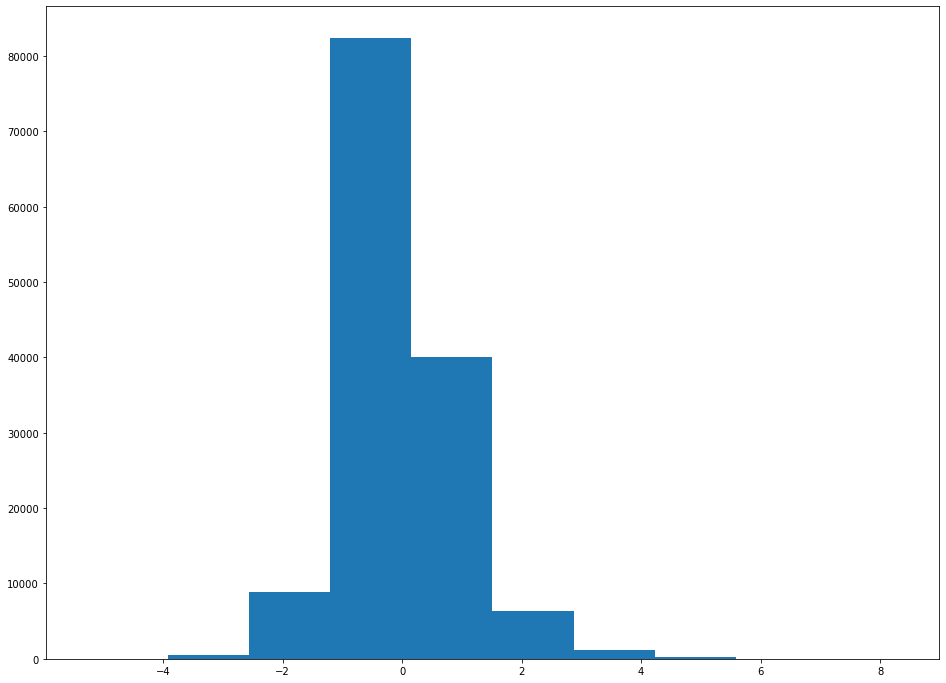

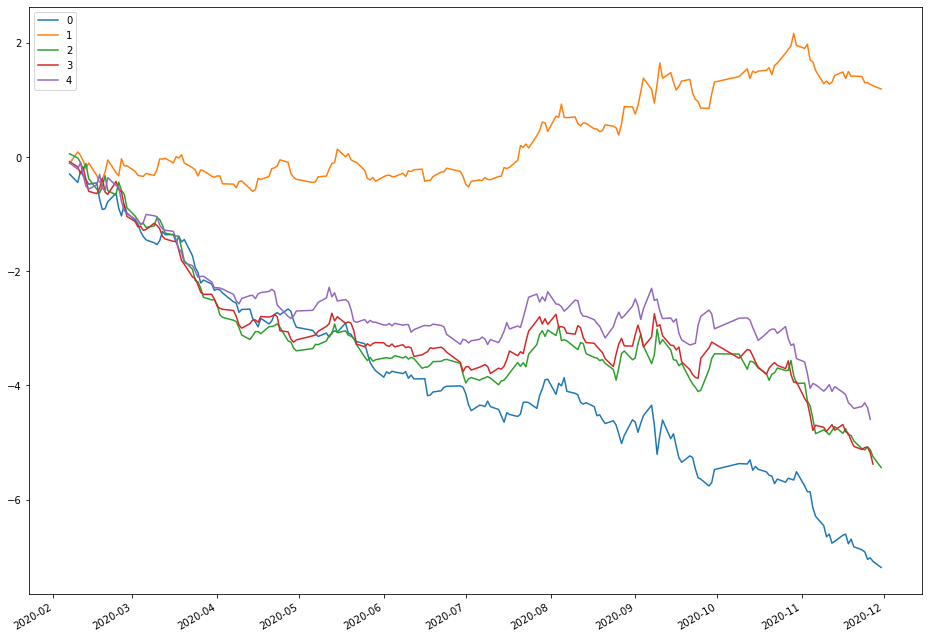

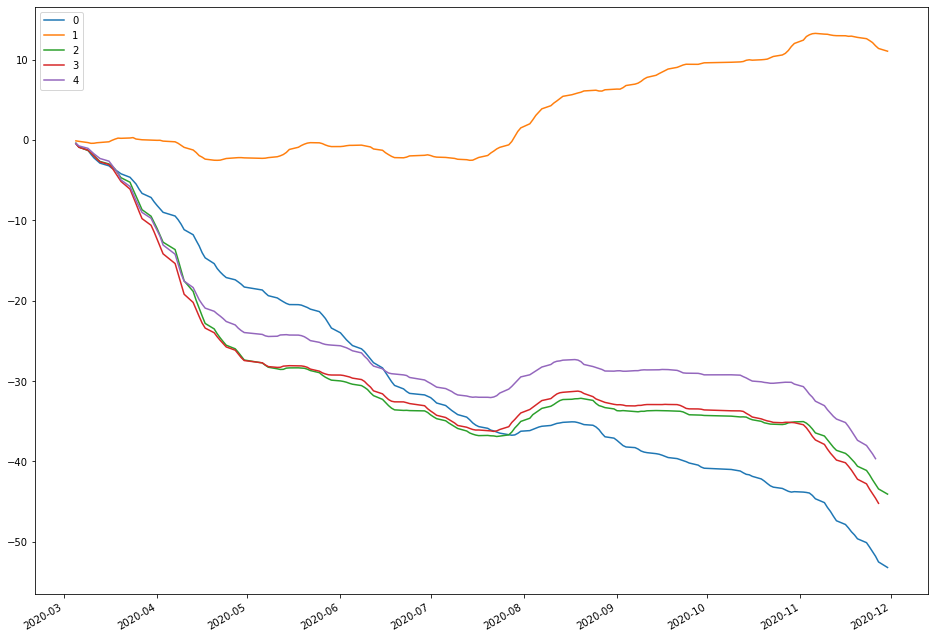

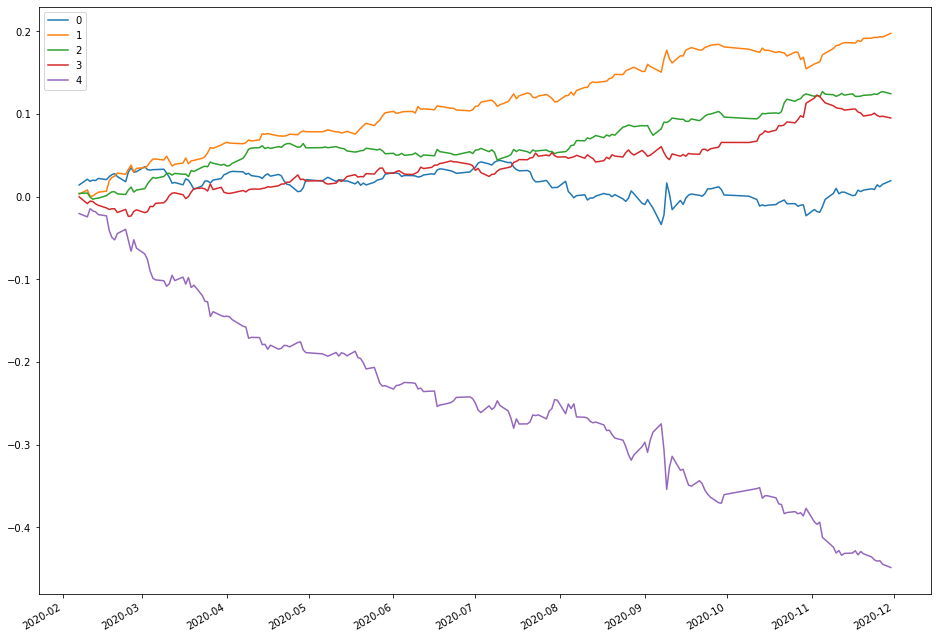

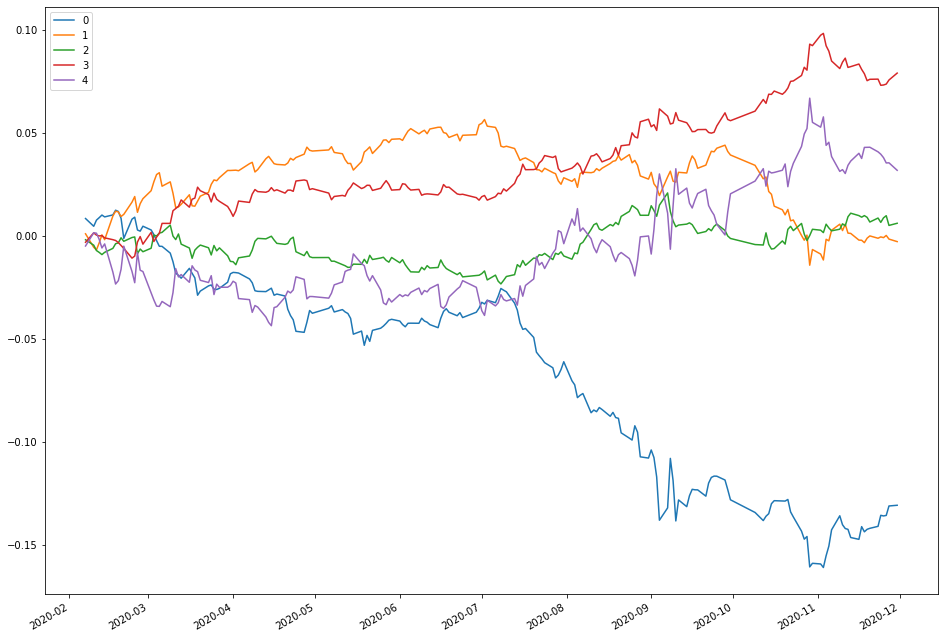

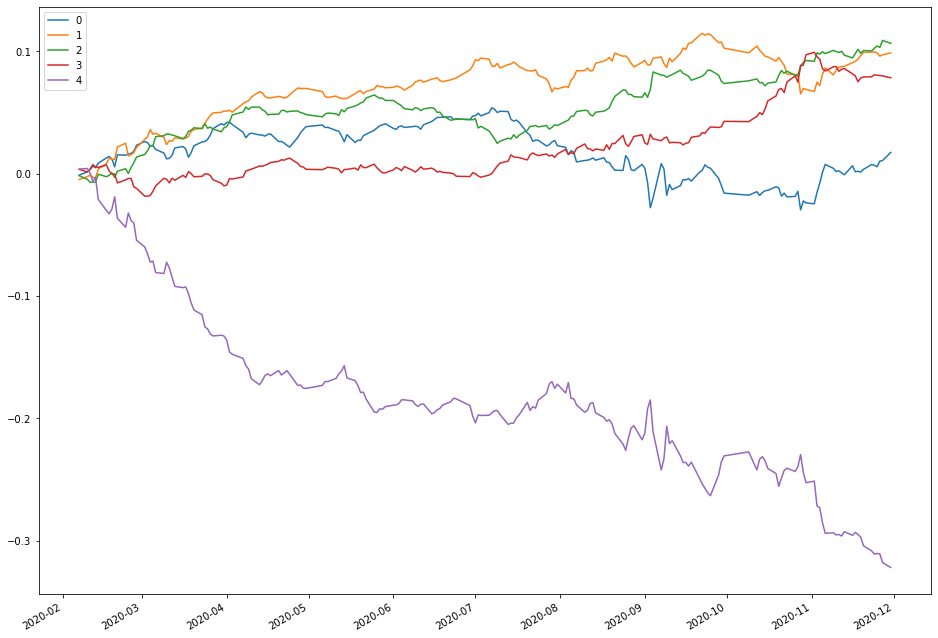

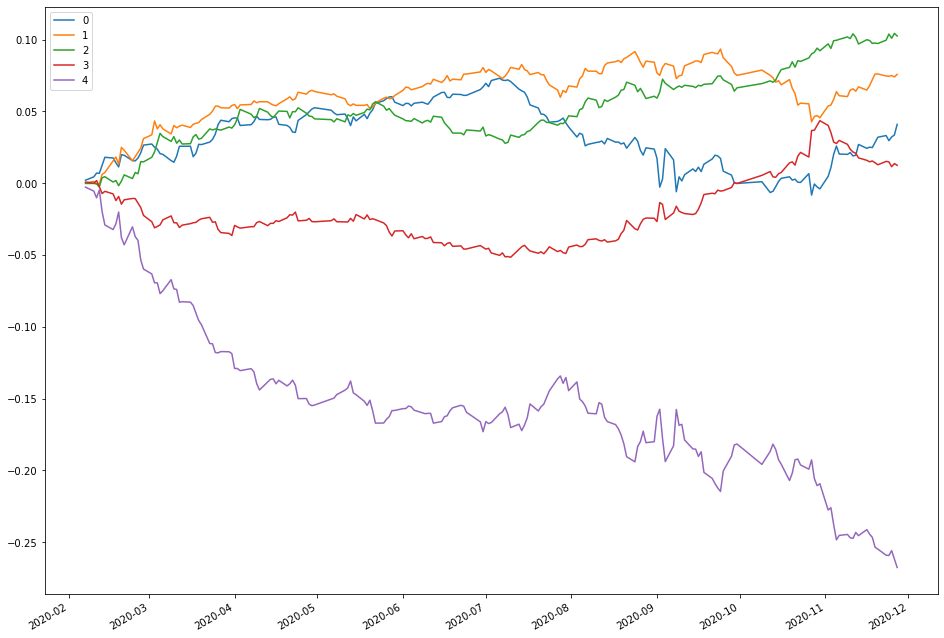

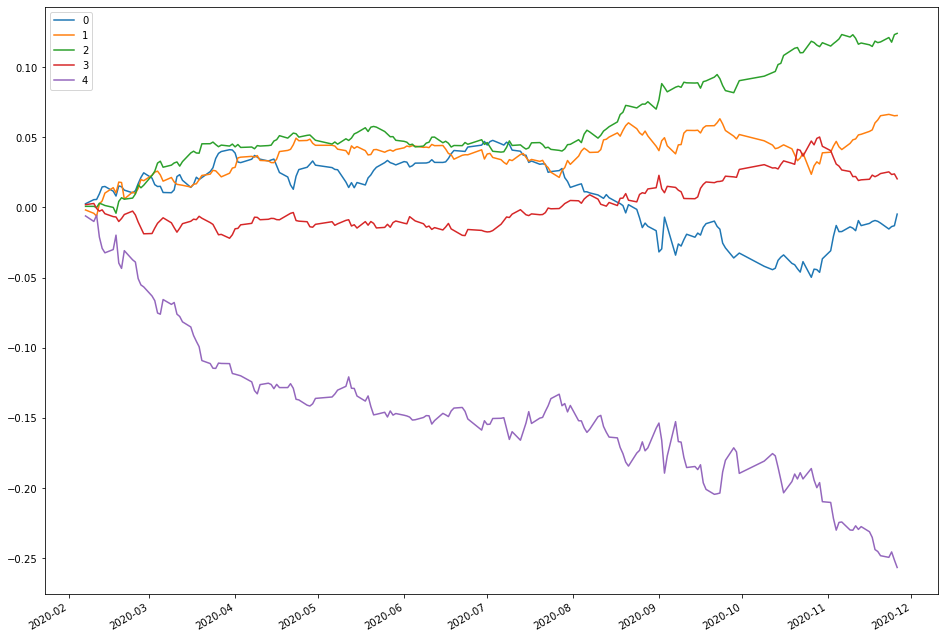

In [8]:
a.factor_analysis()